In [1]:
%matplotlib notebook
from handler import Session
from handler import engine
from leg import Leg
from datetime import datetime
from datetime import date
from datetime import time
from sqlalchemy.sql import text
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import pandas as pd

session = Session()

2018-01-23 08:12:57,521 - root - INFO - SUCCESS: Connection to RDS mysql instance succeeded


## Graph a particular flight

In [2]:
def draw(l, title, filter):
    same = [leg for leg in l if filter(leg)]

    weekdays = [d for d in same if d.departure_date.isoweekday() in range(1,5)]
    friday = [d for d in same if d.departure_date.isoweekday() == 5]
    weekends = [d for d in same if d.departure_date.isoweekday() in (6,7)]

    def prices(lst):
        return [mpldates.date2num(d.departure_date) for d in lst], [d.price for d in lst]

    plt.figure(figsize=(8,8))
    plt.plot_date(prices(weekdays)[0], prices(weekdays)[1], 'g^', label='$Weekdays$')
    plt.plot_date(prices(friday)[0], prices(friday)[1], 'b^', label='$Fridays$')
    plt.plot_date(prices(weekends)[0], prices(weekends)[1], 'r^', label='$Weekends$')
    plt.ylabel('Price (£)')
    plt.xlabel('Departure date')
    plt.title(title)
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


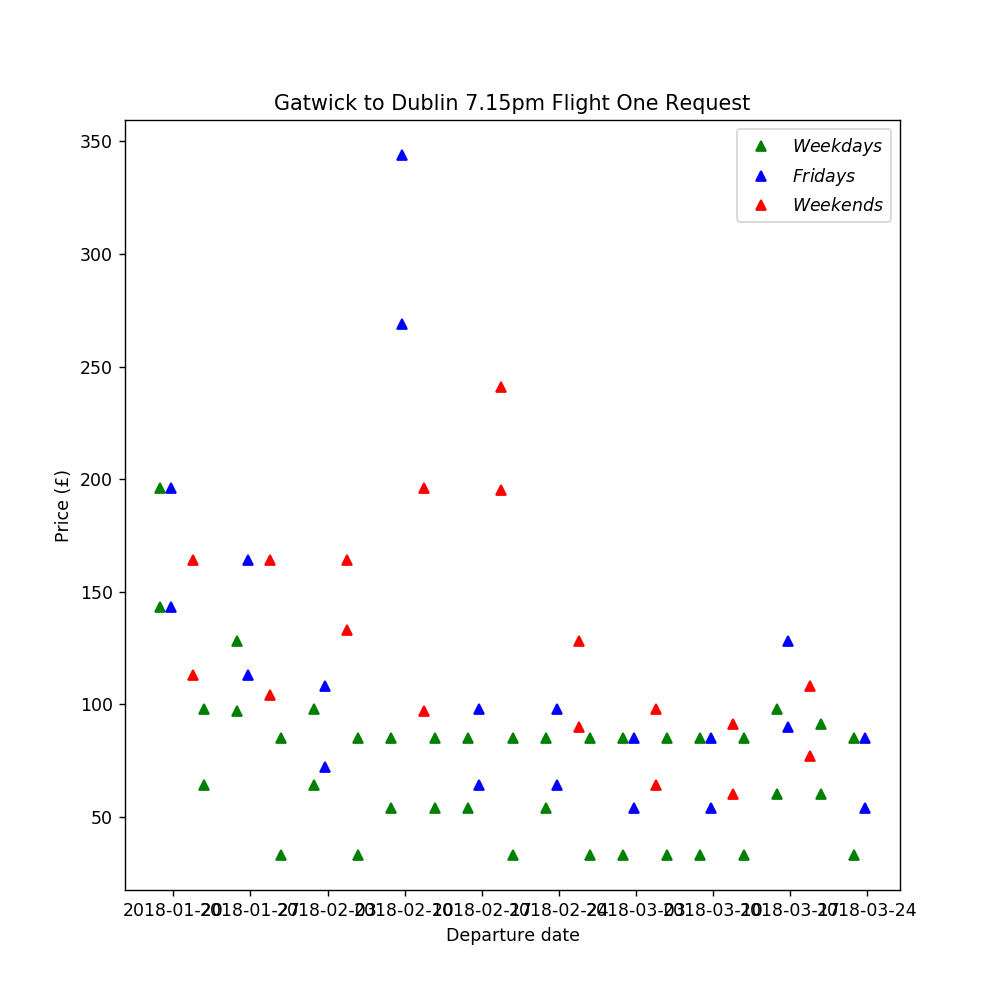

In [3]:
l = session.query(Leg).\
    filter(Leg.departure_location == 'LGW').\
    filter(Leg.arrival_location == 'DUB').\
    filter(Leg.request_time >= datetime(2018,1,17,0,0,0)).\
    filter(Leg.request_time < datetime(2018, 1, 18, 0, 0, 0))

draw(l, 'Gatwick to Dublin 7.15pm Flight One Request', lambda leg: leg.departure_date.time() == time(19, 15))

## Cost of an LGW-DUB flight after 4pm

<IPython.core.display.Javascript object>


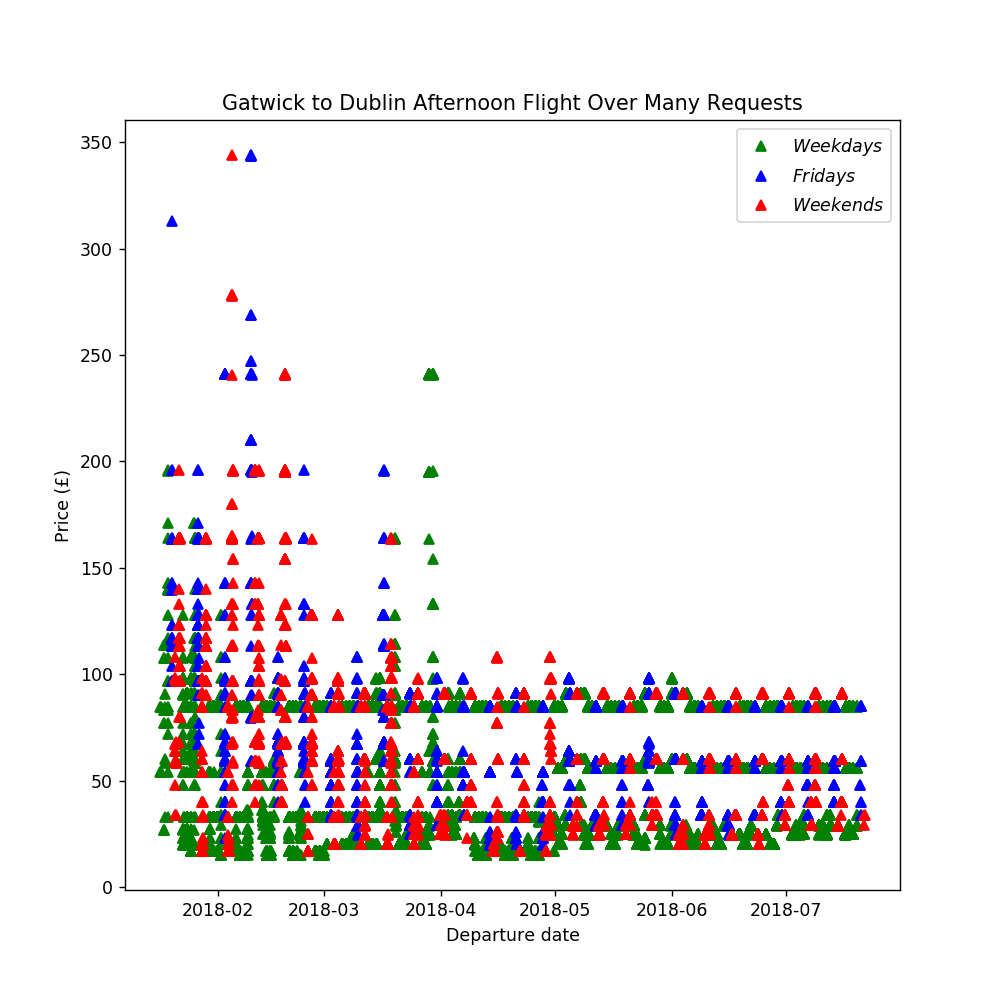

In [4]:
l = session.query(Leg).\
    filter(Leg.departure_location == 'LGW').\
    filter(Leg.arrival_location == 'DUB')

draw(l, 'Gatwick to Dublin Afternoon Flight Over Many Requests', lambda leg: leg.departure_date.time() > time(16, 00))

## LGW to FCO over many requests

<IPython.core.display.Javascript object>


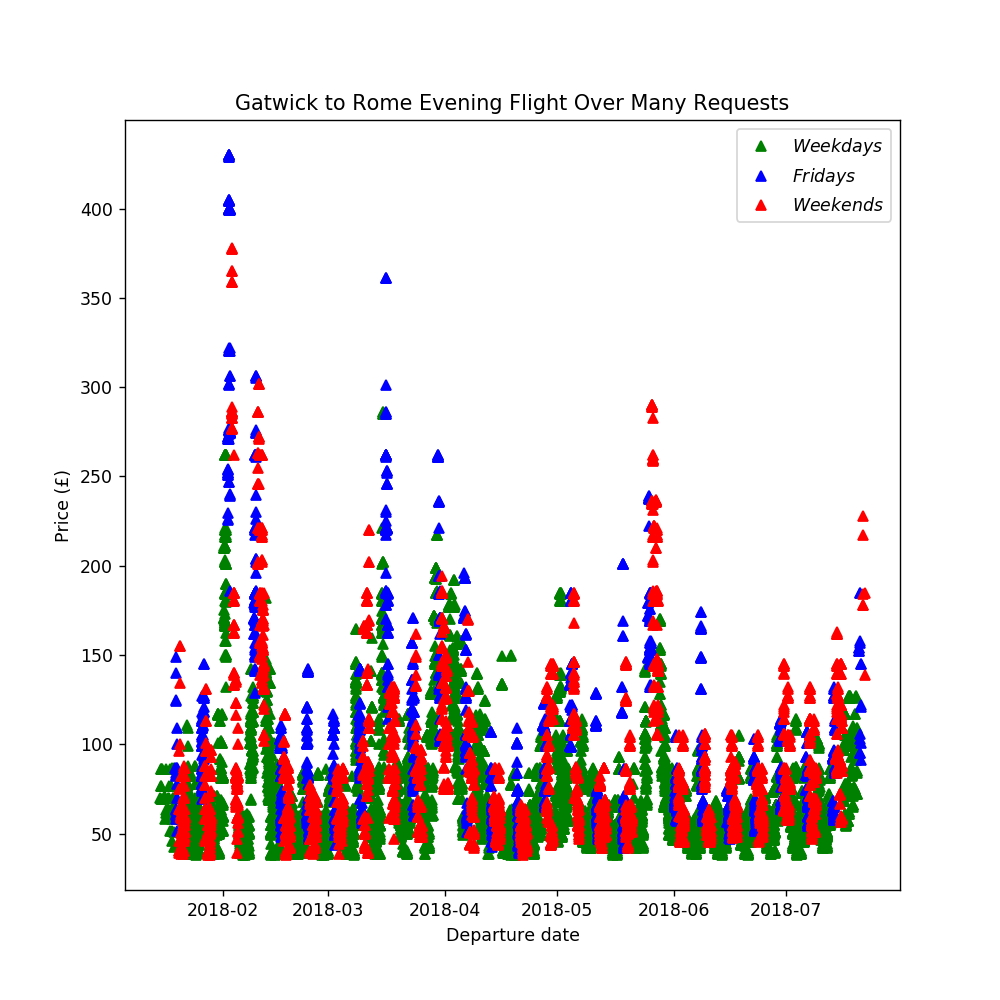

In [5]:
l = session.query(Leg).\
    filter(Leg.departure_location == 'LGW').\
    filter(Leg.arrival_location == 'FCO')

draw(l, 'Gatwick to Rome Evening Flight Over Many Requests', lambda leg: True)

OK, how about drawing lines for the price of 'similar flights', ie with the same airline at similar times of day? (Morning/Afternoon/Evening)

331
313


<IPython.core.display.Javascript object>


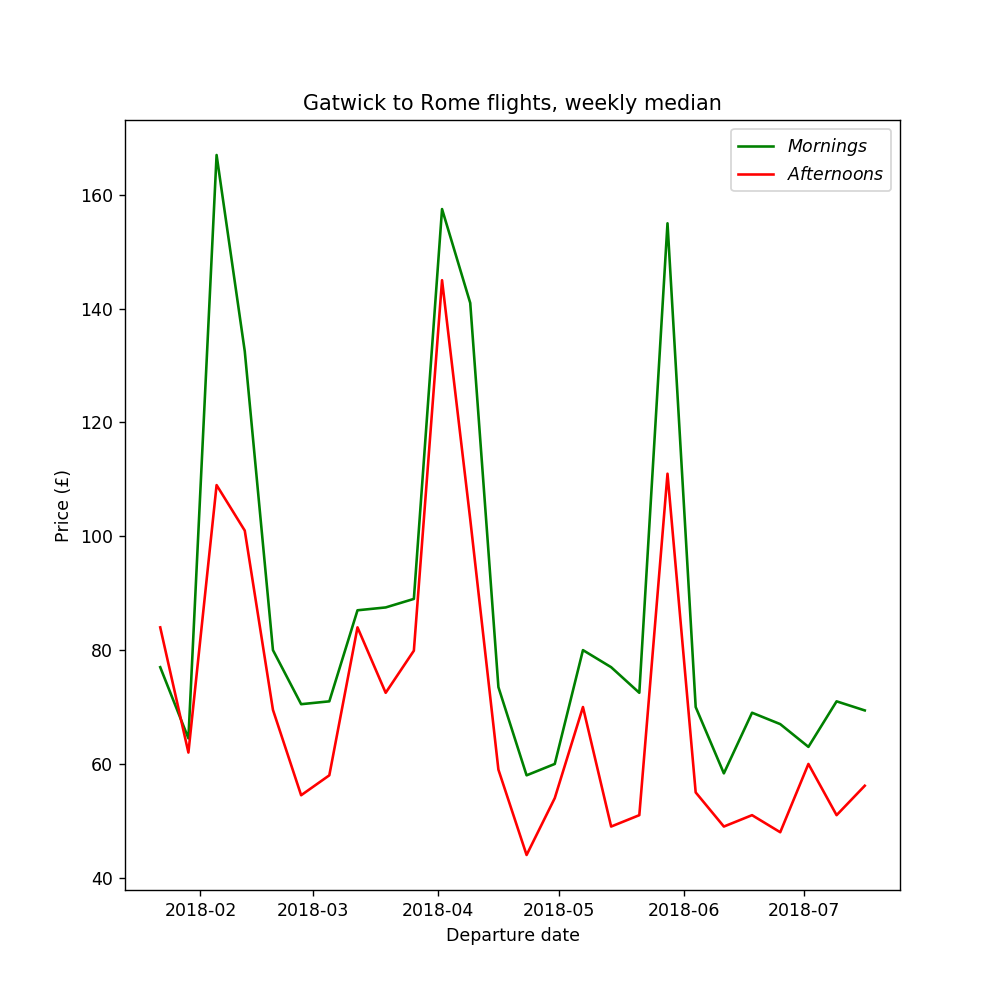

In [6]:
statement = """
    SELECT departure_date, price 
    FROM leg
    WHERE departure_location = 'LGW'
    AND arrival_location = 'FCO'
    AND airline = 'easyJet'
    AND request_time BETWEEN '2018-01-17 00:00:00' AND '2018-01-17 23:59:59'
    """

with engine.connect() as con:
    morning = pd.read_sql(statement+"HAVING HOUR(departure_date) < 12", con)
    afternoon = pd.read_sql(statement+"HAVING HOUR(departure_date) BETWEEN 12 AND 17", con)

    
def weekly_prices(df):
    grouped = df.groupby(pd.Grouper(key='departure_date', freq='W-MON'))['price']\
    .median()\
    .reset_index()\
    .sort_values('departure_date')
    
    mean = df.groupby(pd.Grouper(key='departure_date', freq='W-MON'))['price']\
    .mean()\
    .reset_index()\
    .sort_values('departure_date')['price'].tolist()
    
    median = grouped['price'].tolist()

    return mpldates.date2num(grouped['departure_date'].tolist()), grouped['price']

print(len(morning))
print(len(afternoon))
morning = weekly_prices(morning)
afternoon = weekly_prices(afternoon)

plt.figure(figsize=(8,8))
plt.plot_date(morning[0], morning[1], 'g-', label='$Mornings$')
plt.plot_date(afternoon[0], afternoon[1], 'r-', label='$Afternoons$')

plt.ylabel('Price (£)')
plt.xlabel('Departure date')
plt.title('Gatwick to Rome flights, weekly median')
plt.legend()
plt.show()

## What are those peaks?

    *Holiday*	            *Closing date*	        *Date re-opens*
    Spring half-term 2018	Friday 9 February 2018	Monday 19 February 2018
    Easter 2018	            Thursday 29 March 2018  Monday 16 April 2018
    May Day 2018	        Friday 4 May 2018	    Tuesday 8 May 2018
    Summer half-term 2018	Friday 25 May 2018	    Monday 4 June 2018